# Calculate ice transport from CESM2-LE

* **Description**: Reads in and creates ice export timeseries from rufmod experiment
* **Input data**: CESM2-LE data, read using intake-esm
* **Output data**: Netcdf with processed ice state for all members
* **Creator**: Alice DuVivier
* **Date**: February 2022

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pop_tools
from datetime import timedelta
import glob
import dask
from matplotlib.gridspec import GridSpec
import pandas as pd
import cartopy
import cartopy.crs as ccrs

import intake
from distributed import Client
from ncar_jobqueue import NCARCluster


Spin up dask cluster

In [2]:
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=2, # The number of cores you want
    memory='32 GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    #resource_spec='select=1:ncpus=2:mem=256GB', # Specify resources
    project='P93300665', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)
# Scale up
cluster.scale(32)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.56:40317,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Read the CESM-LE data 

We will use [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/), which is a data catalog tool.
It enables querying a database for the files we want, then loading those directly as an `xarray.Dataset`.

First step is to set the "collection" for the CESM-LE, which depends on a json file conforming to the [ESM Catalog Specification](https://github.com/NCAR/esm-collection-spec).

In [4]:
# list the variables to load
var_in_1 = 'sidmasstranx'
var_in_2 = 'sidmasstrany'

# sidmasstranx (for Fram and Barents), sidmasstrany (for Bering)

In [5]:
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'

cat = intake.open_esm_datastore(catalog_file)

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/intake_esm/core.py:84: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  self._df, self.catalog_file = _fetch_catalog(self.esmcol_data, esmcol_obj, csv_kwargs)


In [6]:
forcing = 'cmip6'  # do not want smbb data
exp = 'ssp370'

subset_1 = cat.search(variable=var_in_1, forcing_variant = forcing, experiment=exp)
subset_2 = cat.search(variable=var_in_2, forcing_variant = forcing, experiment=exp)

In [7]:
subset_1

,unique
component,1
stream,1
case,50
member_id,50
variable,1
start_time,9
end_time,9
time_range,9
long_name,1
units,1


In [8]:
subset_2

,unique
component,1
stream,1
case,50
member_id,50
variable,1
start_time,9
end_time,9
time_range,9
long_name,1
units,1


In [9]:
# check that we only have cmip6, not smbb, data
member_id = list(subset_1.df.forcing_variant.unique())
print(member_id)

['cmip6']


In [10]:
subset_1.df.head()

,component,stream,case,member_id,variable,start_time,end_time,time_range,long_name,units,vertical_levels,frequency,path,experiment,forcing_variant,cesm_member_id,control_branch_year,cmip_experiment_id
0,ice,cice.h,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,sidmasstranx,2015-01,2024-12,201501-202412,x component of snow and sea ice mass transport,kg/s,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
1,ice,cice.h,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,sidmasstranx,2025-01,2034-12,202501-203412,x component of snow and sea ice mass transport,kg/s,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
2,ice,cice.h,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,sidmasstranx,2035-01,2044-12,203501-204412,x component of snow and sea ice mass transport,kg/s,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
3,ice,cice.h,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,sidmasstranx,2045-01,2054-12,204501-205412,x component of snow and sea ice mass transport,kg/s,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
4,ice,cice.h,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,sidmasstranx,2055-01,2064-12,205501-206412,x component of snow and sea ice mass transport,kg/s,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1


Now we can use the [`to_dataset_dict`](https://intake-esm.readthedocs.io/en/latest/api.html#intake_esm.core.esm_datastore.to_dataset_dict) method to return a dictionary of `xarray.Dataset`'s. `intake_esm` makes groups of these according to rules in the collection spec file.

We can use the `preprocess` parameter to pass in a function that makes some corrections to the dataset. So first we define a function that does the following:
- fix the time coordinate to be the middle of the interval
- subset to the time-interval 1950-2100

In [11]:
client

<Client: 'tcp://10.12.206.56:40317' processes=32 threads=64, memory=800.00 GiB>

In [12]:
%%time
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsets_1 = subset_1.to_dataset_dict(cdf_kwargs={'chunks': {'time':240}, 'decode_times': True})

with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsets_2 = subset_2.to_dataset_dict(cdf_kwargs={'chunks': {'time':240}, 'decode_times': True})



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 13.2 s, sys: 554 ms, total: 13.7 s
Wall time: 21.5 s


In [13]:
# print names of the dataset keys. 
dsets_1.keys()

dict_keys(['ice.ssp370.cice.h.cmip6.sidmasstranx'])

In [14]:
dsets_2.keys()

dict_keys(['ice.ssp370.cice.h.cmip6.sidmasstrany'])

In [15]:
# load in the future datasets for var_in_1
futures_1 = []

for key in sorted(dsets_1.keys()):
    futures_1.append(dsets_1[key])
    print(key)

ice.ssp370.cice.h.cmip6.sidmasstranx


In [16]:
# load in the future datasets for var_in_1

futures_2 = []

for key in sorted(dsets_2.keys()):
    futures_2.append(dsets_2[key])
    print(key)

ice.ssp370.cice.h.cmip6.sidmasstrany


In [17]:
# Now put these into an array
future_ds_1 = xr.concat(futures_1, dim='member_id')
future_ds_2 = xr.concat(futures_2, dim='member_id')

In [18]:
# note that the historical and future xarray datasets have the same coordinates and dimensions *except* time, 
# so we need to concatenate over time
ds_all_1 = future_ds_1
ds_all_2 = future_ds_2

In [19]:
ds_all_1[var_in_1]

<xarray.DataArray 'sidmasstranx' (member_id: 50, time: 1032, nj: 384, ni: 320)>
dask.array<concatenate, shape=(50, 1032, 384, 320), dtype=float32, chunksize=(1, 120, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    TLON       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULON       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time       (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: nj, ni
Attributes:
    units:          kg/s
    long_name:      x component of snow and sea ice mass transport
    cell_measures:  area: uarea
    cell_methods:   time: mean
    time_rep:       averaged

In [20]:
ds_all_1.time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 4, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2101, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    long_name:  model time
    bounds:     time_bounds

In [21]:
# Shift months by one to be center of time period.
# Take average of the time bounds to get middle of month
# will lose some attributes with time, so may need to put this back in later...
ds_all_1.time_bounds.load().mean(dim='d2').sel(member_id='r1i1281p1f1')

<xarray.DataArray 'time_bounds' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time       (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
    member_id  <U12 'r1i1281p1f1'

In [22]:
ds_all_1['time'] = ds_all_1.time_bounds.load().mean(dim='d2').sel(member_id='r1i1281p1f1')
ds_all_2['time'] = ds_all_2.time_bounds.load().mean(dim='d2').sel(member_id='r1i1281p1f1')

In [23]:
ds_all_1.time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00

In [24]:
# set some info for output
longname = 'total snow and sea ice mass transport through gate'
units = ds_all_1[var_in_1].units

## Check flux gates where we are going to calculate transport

In [25]:
# Just select one variable, one member, one time 
# to make sure we have correct locations
data_temp1 = ds_all_1[var_in_1].sel(member_id='r1i1281p1f1').isel(time=2)
data_temp2 = ds_all_2[var_in_2].sel(member_id='r1i1281p1f1').isel(time=2)

In [26]:
data_temp1.load()
data_temp2.load()

<xarray.DataArray 'sidmasstrany' (nj: 384, ni: 320)>
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [39427.656, 76598.125, 39094.953, ...,       nan,       nan,
              nan],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)
Coordinates:
    TLON       (nj, ni) float32 320.6 321.7 322.8 323.9 ... nan nan nan nan
    TLAT       (nj, ni) float32 -79.22 -79.22 -79.22 -79.22 ... nan nan nan nan
    ULON       (nj, ni) float32 321.1 322.2 323.4 324.5 ... nan nan nan nan
    ULAT       (nj, ni) float32 -78.95 -78.95 -78.95 -78.95 ... nan nan nan nan
    time       object 2015-03-16 12:00:00
    member_id  <U12 'r1i1281p1f1'
Dimensions without coordinates: nj, ni
Attributes:
    units:          kg/s
    long_name:      y component of snow and sea ice mass transport
    cell_measures:  area: uarea
    cell_methods:   time: mean
    time_rep:       averaged

### Bering Strait checks

In [27]:
# Indices from Marika: i=198:199, j=331

# Indices we're using
ii_ber_min = 199
ii_ber_max = 201
jj_ber  = 332

# general area
data_npac = data_temp2.loc[jj_ber-10:jj_ber+10,ii_ber_min-10:ii_ber_min+10]
# Just the flux gate
data_ber = data_temp2.loc[jj_ber,ii_ber_min:ii_ber_max]

In [28]:
# Stack into 1D array (400pts)
data_npac_1d = data_npac.stack(horizontal=("nj","ni"))

In [29]:
# Drop nans (243 pts)
data_npac_1d = data_npac_1d.where(abs(data_npac_1d)>=0, drop=True)

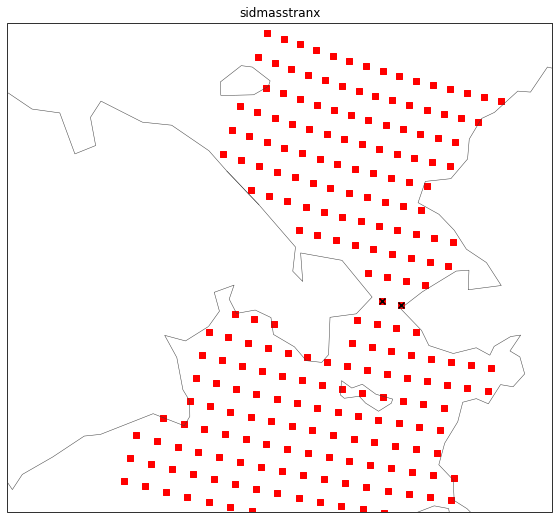

In [30]:
# Want to check that we're plotting the correct area for the training data
# using pcolor here
lon_min = 170
lon_max = 200
lon_avg = 190
lat_min = 60
lat_max = 72

fig = plt.figure(figsize=(12,9))

ax = plt.axes(projection=ccrs.Stereographic(central_longitude=lon_avg))

# Scatter plot where the data exist
cs1 = ax.scatter(    data_npac_1d.coords['TLON'].values,    
                     data_npac_1d.coords['TLAT'].values,
                     c='red', marker='s',
                     transform=ccrs.PlateCarree())

ax.set_extent([lon_min,lon_max,lat_min,lat_max], ccrs.PlateCarree())

ax.coastlines(resolution='110m', color='0.25', linewidth=0.5, zorder=10)  

ax.set_title(var_in_1, fontsize=12)

# scatter - add x's over the data for our "gate" points
ax.scatter(          data_ber.coords['TLON'].values,    
                     data_ber.coords['TLAT'].values, 
                     c='black', marker='x',
                     transform=ccrs.PlateCarree())

# show the finished plot
plt.show()

In [31]:
print('Bering values Lats')
print(data_ber['TLAT'].values)
print('Bering values Lons')
print(data_ber['TLON'].values)

Bering values Lats
[65.88094  65.768776]
Bering values Lons
[190.69955 191.91072]


### Fram Strait and Barents Sea checks

In [32]:
# Just look at Fram and Barents gates
# Indices from Marika: Fram i=99, j=370:379; Barents i=99, j=351:365

# fram strait
ii_fram     = 100
jj_fram_min = 369
jj_fram_max = 381

# barents sea
ii_bar      = 85
jj_bar_min  = 345
jj_bar_max  = 367

# general area
data_natl = data_temp1.loc[jj_bar_min-30:jj_fram_min+30,ii_fram-30:ii_fram+30]
# Just the flux gates
data_trans = data_temp1.loc[348:385,ii_fram]
data_fram = data_temp1.loc[jj_fram_min:jj_fram_max,ii_fram]
data_bar  = data_temp1.loc[jj_bar_min:jj_bar_max,ii_bar]

In [33]:
# Stack into 1D array (880pts)
data_natl_1d = data_natl.stack(horizontal=("nj","ni"))

In [34]:
# Drop nans (671 pts)
data_natl_1d = data_natl_1d.where(abs(data_natl_1d)>=0, drop=True)

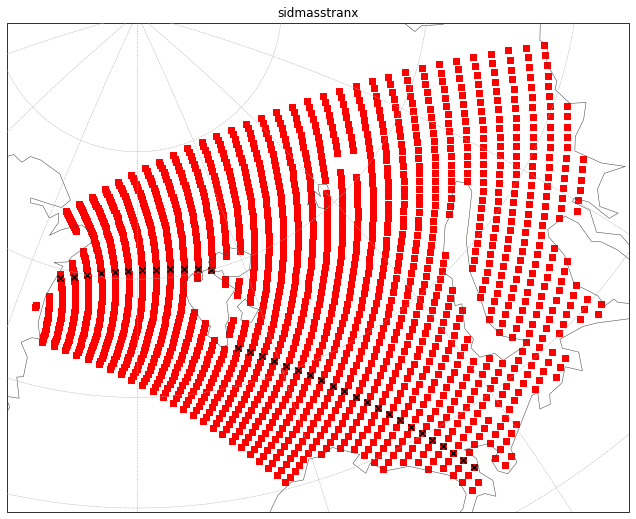

In [35]:
# Want to check that we're plotting the correct area for the training data
lon_avg = 0

fig = plt.figure(figsize=(12,9))

ax = plt.axes(projection=ccrs.Stereographic(central_longitude=lon_avg))

ax.set_title(var_in_1, fontsize=12)

# Scatter plot where the data exist
ax.scatter(    data_natl_1d.coords['TLON'].values,    
                     data_natl_1d.coords['TLAT'].values,
                     c='red', marker='s',
                     transform=ccrs.PlateCarree())

ax.coastlines(resolution='110m', color='0.25', linewidth=0.5, zorder=10)  

ax.gridlines(linestyle='--', linewidth=0.5, zorder=11)

# scatter - add x's over the data for our "gate" points
ax.scatter(         data_fram.coords['TLON'].values,    
                     data_fram.coords['TLAT'].values, 
                     c='black', marker='x', transform=ccrs.PlateCarree())

ax.scatter(         data_bar.coords['TLON'].values,    
                     data_bar.coords['TLAT'].values, 
                     c='black', marker='x', transform=ccrs.PlateCarree())

plt.show()

In [36]:
print('Fram values Lats')
print(data_fram['TLAT'].values)
print('Fram values Lons')
print(data_fram['TLON'].values)

Fram values Lats
[79.99461  80.13713  80.245255 80.317955 80.35453  80.3547   80.31858
 80.24671  80.14     79.99971  79.82737  79.62472 ]
Fram values Lons
[ 17.640366   14.4751     11.229635    7.9261312   4.589294    1.2454064
 357.92117   354.64252   351.43356   348.3156    345.30655   342.42056  ]


In [37]:
print('Barents values Lats')
print(data_bar['TLAT'].values)
print('Barents values Lons')
print(data_bar['TLON'].values)

Barents values Lats
[67.70895  68.20153  68.69011  69.17438  69.65399  70.128586 70.59774
 71.06103  71.51796  71.968025 72.41065  72.84522  73.27107  73.68747
 74.093636 74.48872  74.87182  75.24194  75.598045 75.939026 76.26369
 76.570816]
Barents values Lons
[43.40761  42.771652 42.100445 41.391735 40.643124 39.852062 39.01583
 38.131565 37.196224 36.20661  35.159386 34.051052 32.87801  31.636553
 30.322927 28.933376 27.464205 25.911865 24.273056 22.544855 20.72485
 18.81132 ]


### Central Arctic checks

In [38]:
# Just look at New "central Arctic" gate

# central arctic
ii_cen      = 135
jj_cen_min  = 355
jj_cen_max  = 378

# general area
data_natl = data_temp1.loc[jj_cen_min-30:jj_cen_min+30,ii_cen-30:ii_cen+30]
# Just the flux gates
data_cen  = data_temp1.loc[jj_cen_min:jj_cen_max,ii_cen]

In [39]:
# Stack into 1D array (880pts)
data_natl_1d = data_natl.stack(horizontal=("nj","ni"))

In [40]:
# Drop nans (671 pts)
data_natl_1d = data_natl_1d.where(abs(data_natl_1d)>=0, drop=True)

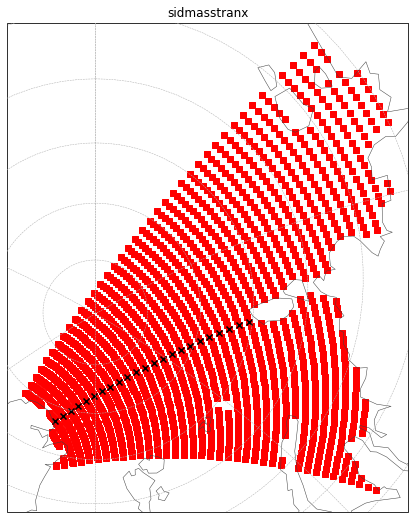

In [42]:
# Want to check that we're plotting the correct area for the training data
lon_avg = 0

fig = plt.figure(figsize=(12,9))

ax = plt.axes(projection=ccrs.Stereographic(central_longitude=lon_avg))

ax.set_title(var_in_1, fontsize=12)

# Scatter plot where the data exist
ax.scatter(    data_natl_1d.coords['TLON'].values,    
                     data_natl_1d.coords['TLAT'].values,
                     c='red', marker='s',
                     transform=ccrs.PlateCarree())

ax.coastlines(resolution='110m', color='0.25', linewidth=0.5, zorder=10)  

ax.gridlines(linestyle='--', linewidth=0.5, zorder=11)

# scatter - add x's over the data for our "gate" points
ax.scatter(         data_cen.coords['TLON'].values,    
                     data_cen.coords['TLAT'].values, 
                     c='black', marker='x', transform=ccrs.PlateCarree())

plt.show()

In [43]:
print('CenArc values Lats')
print(data_cen['TLAT'].values)
print('CenArc values Lons')
print(data_cen['TLON'].values)

CenArc values Lats
[81.189064 81.7314   82.26057  82.77398  83.26837  83.739624 84.18256
 84.59071  84.95618  85.26966  85.52092  85.69974  85.797646 85.809746
 85.73612  85.58185  85.35574  85.06843  84.730644 84.352135 83.94119
 83.50461  83.04784 ]
CenArc values Lons
[ 91.52451    89.53861    87.2746     84.681175   81.69732    78.25184
  74.264626   69.65119    64.333084   58.25693    51.42298    43.91787
  35.935947   27.767683   19.745874   12.17013     5.2485476 359.08075
 353.67615   348.98645   344.93515   341.4378    338.41342  ]


## Calculate fluxes across gates

In [44]:
# fram strait
ii_fram     = 100
jj_fram_min = 369
jj_fram_max = 381

# barents sea
ii_bar      = 85
jj_bar_min  = 345
jj_bar_max  = 367

# central arctic
ii_cen      = 135
jj_cen_min  = 355
jj_cen_max  = 378

# bering sea
ii_ber_min = 199
ii_ber_max = 201
jj_ber  = 332


In [45]:
sidmasstranx = ds_all_1[var_in_1]
sidmasstrany = ds_all_2[var_in_2]

#sidmasstranx = ds_all['sidmasstranx']
#sidmasstrany = ds_all['sidmasstrany']

In [46]:
sidmasstranx

,Array,Chunk
Bytes,23.62 GiB,56.25 MiB
Shape,"(50, 1032, 384, 320)","(1, 120, 384, 320)"
Count,2250 Tasks,450 Chunks
Type,float32,numpy.ndarray


In [47]:
# Get data for each of the gates
# We use sidmasstranx for the fram and barents gates and 
# sidmasstrany for the bering gate because of how they line up with the grid

data_fram = sidmasstranx[:,:,jj_fram_min:jj_fram_max,ii_fram]
data_bar  = sidmasstranx[:,:,jj_bar_min:jj_bar_max,ii_bar]
data_cen  = sidmasstranx[:,:,jj_cen_min:jj_cen_max,ii_cen]
data_ber  = sidmasstrany[:,:,jj_ber,ii_ber_min:ii_ber_max]

In [48]:
# now sum up total mass fluxes across the gates
# we have the follow points for each gate: fram(12), barents(16), bering(2)
# final dimensions will be just time x n_ens

data_fram = data_fram.sum(dim='nj')
data_bar  = data_bar.sum(dim='nj')
data_cen  = data_cen.sum(dim='nj')
data_ber  = data_ber.sum(dim='ni')

In [49]:
data_fram.sel(member_id='r1i1281p1f1').values

array([-71443680. , -54982656. , -32556602. , ...,         0. ,
               0. ,   -789193.4], dtype=float32)

### Actually load the data now

Before, all the calculations were "lazy" version

In [50]:
%%time
## slow step
data_fram.load()
data_bar.load()
data_cen.load()
data_ber.load()

CPU times: user 6.95 s, sys: 272 ms, total: 7.22 s
Wall time: 17.8 s


<xarray.DataArray 'sidmasstrany' (member_id: 50, time: 1032)>
array([[ 3860350.8  , -1218832.8  ,  7473788.   , ...,        0.   ,
               0.   ,        0.   ],
       [ 2728124.8  ,  -783398.75 ,  7549013.   , ...,        0.   ,
               0.   ,        0.   ],
       [       0.   ,   -55652.633,  2756148.   , ...,        0.   ,
               0.   ,        0.   ],
       ...,
       [ 2552049.5  ,   414365.38 , -3041344.8  , ...,        0.   ,
               0.   ,        0.   ],
       [ 4068583.5  , 10634096.   ,  6784927.   , ...,        0.   ,
               0.   ,        0.   ],
       [  980879.   ,  4910196.5  , 10616380.   , ...,        0.   ,
               0.   ,        0.   ]], dtype=float32)
Coordinates:
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'

In [51]:
data_fram.coords

Coordinates:
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'

In [52]:
data_fram

<xarray.DataArray 'sidmasstranx' (member_id: 50, time: 1032)>
array([[-7.03923680e+07, -3.46017520e+07, -4.49241560e+07, ...,
         0.00000000e+00, -1.27860484e+05, -6.45986450e+06],
       [-5.92965240e+07, -1.14723790e+07, -9.87861200e+07, ...,
         0.00000000e+00,  0.00000000e+00, -3.25957562e+05],
       [-8.33116000e+07, -7.92873200e+07, -6.09080200e+07, ...,
         0.00000000e+00,  0.00000000e+00,  1.19573218e+03],
       ...,
       [-7.82990560e+07, -7.46918640e+07, -1.14563960e+08, ...,
        -2.80886406e+05, -1.40077109e+04, -3.09338175e+06],
       [-8.37916400e+07, -1.00258720e+08, -1.01108952e+08, ...,
         0.00000000e+00, -3.22283740e+03, -4.58771150e+06],
       [-6.45736600e+07, -1.09265304e+08, -1.46058736e+08, ...,
         0.00000000e+00,  0.00000000e+00, -1.27204938e+06]], dtype=float32)
Coordinates:
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'

### Plot just to check

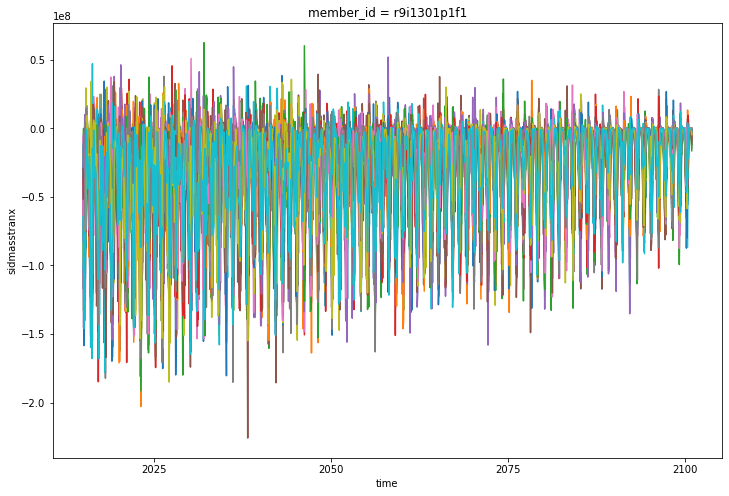

In [53]:
import nc_time_axis
# Setup the figure
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)

# Loop through and plot each member_id all months in 251 years
for member_id in data_fram.member_id.values:
    data_fram.sel(member_id=member_id).plot(ax=ax, label=member_id)

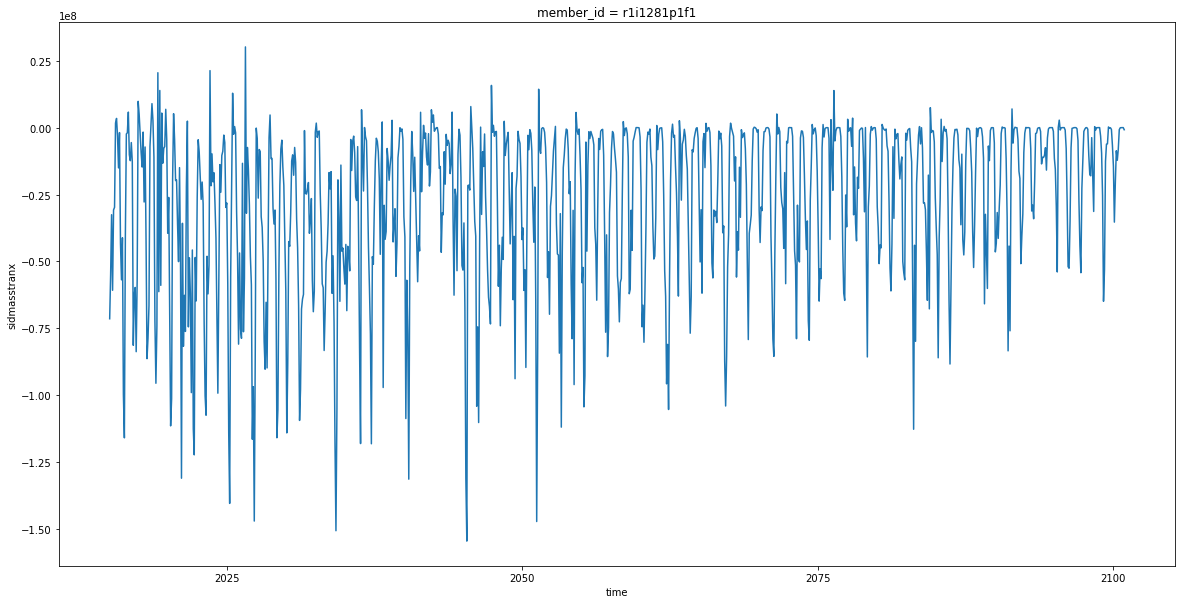

In [54]:
# Setup the figure
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(111)

# Plot just one to check
data_fram.sel(member_id='r1i1281p1f1').plot(ax=ax, label='r1i1281p1f1')

### Save the timeseries

In [55]:
fout = 'CESM2-LE_mass_fluxes'

In [56]:
data_fram

<xarray.DataArray 'sidmasstranx' (member_id: 50, time: 1032)>
array([[-7.03923680e+07, -3.46017520e+07, -4.49241560e+07, ...,
         0.00000000e+00, -1.27860484e+05, -6.45986450e+06],
       [-5.92965240e+07, -1.14723790e+07, -9.87861200e+07, ...,
         0.00000000e+00,  0.00000000e+00, -3.25957562e+05],
       [-8.33116000e+07, -7.92873200e+07, -6.09080200e+07, ...,
         0.00000000e+00,  0.00000000e+00,  1.19573218e+03],
       ...,
       [-7.82990560e+07, -7.46918640e+07, -1.14563960e+08, ...,
        -2.80886406e+05, -1.40077109e+04, -3.09338175e+06],
       [-8.37916400e+07, -1.00258720e+08, -1.01108952e+08, ...,
         0.00000000e+00, -3.22283740e+03, -4.58771150e+06],
       [-6.45736600e+07, -1.09265304e+08, -1.46058736e+08, ...,
         0.00000000e+00,  0.00000000e+00, -1.27204938e+06]], dtype=float32)
Coordinates:
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'

In [57]:
ds_to_save = xr.Dataset({'flux_fram': (['member_id','time'], data_fram.data),
                         'flux_barents': (['member_id','time'], data_bar.data),
                         'flux_arcoc': (['member_id','time'], data_cen.data),
                         'flux_bering': (['member_id','time'], data_ber.data)},
                        coords={'time':(['time'],data_fram.time.values),
                                'member_id':(['member_id'],data_fram.member_id.values)},
                        attrs={'Author': 'Alice DuVivier', 'units':units, 'longname':longname})

In [58]:
# double check dataset we plan to save
ds_to_save

<xarray.Dataset>
Dimensions:       (member_id: 50, time: 1032)
Coordinates:
  * time          (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id     (member_id) <U12 'r10i1181p1f1' ... 'r9i1301p1f1'
Data variables:
    flux_fram     (member_id, time) float32 -7.039e+07 -3.46e+07 ... -1.272e+06
    flux_barents  (member_id, time) float32 -2.748e+06 -5.33e+06 ... 0.0 0.0
    flux_arcoc    (member_id, time) float32 -2.591e+07 -1.814e+07 ... -5.156e+06
    flux_bering   (member_id, time) float32 3.86e+06 -1.219e+06 ... 0.0 0.0
Attributes:
    Author:    Alice DuVivier
    units:     kg/s
    longname:  total snow and sea ice mass transport through gate

In [59]:
ds_to_save.to_netcdf(fout+'.nc')  # how to save file